In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia import config
from data_scientia.data import capacidad_hospitalaria
from data_scientia.features import critical_peaks
from data_scientia.features import target_days_to_peak

/Users/lsanchez/anaconda3/envs/data_scientia/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/lsanchez/anaconda3/envs/data_scientia/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
config.VERBOSE = False

data = capacidad_hospitalaria.get()
data.shape

(17011, 15)

In [4]:
data.head()

,datasetid,recordid,record_timestamp,estatus_capacidad_hospitalaria,fecha,coordenadas,institucion,nombre_hospital,estatus_capacidad_uci,geometry.type,geometry.coordinates,estatus_capacidad_uci_percent,estatus_capacidad_uci_ordinal,latitude,longitude
0,capacidad-hospitalaria,b49b9f2f841f7e4308922b96b9935dfd54043260,2020-11-30T16:04:15.140000+00:00,Media,2020-04-14,"[19.289599, -99.155441]",SSA,INSTITUTO NACIONAL DE NUTRICIÓN,Buena,Point,"[-99.155441, 19.289599]",49.0,1.0,19.289599,-99.155441
1,capacidad-hospitalaria,99c40921ef5ae9650ab60a181c0b1e539b6fae76,2020-11-30T16:04:15.140000+00:00,Media,2020-04-14,"[19.291375, -99.158653]",SSA,INSTITUTO NACIONAL DE ENFERMEDADES RESPIRATORIAS,Buena,Point,"[-99.158653, 19.291375]",49.0,1.0,19.291375,-99.158653
2,capacidad-hospitalaria,9f83212289548045ff58651dbc195a2636fa744d,2020-11-30T16:04:15.140000+00:00,Media,2020-04-14,"[19.4129258, -99.1520225]",SSA,HOSPITAL GENERAL DE MÉXICO,Buena,Point,"[-99.1520225, 19.4129258]",49.0,1.0,19.412926,-99.152023
3,capacidad-hospitalaria,166c827f50b13d44c090ed586c94348d27ea6032,2020-11-30T16:04:15.140000+00:00,Media,2020-04-14,"[19.307226, -99.065356]",SEDESA,HOSPITAL DE ESPECIALIDADES DE LA CIUDAD DE MÉX...,Media,Point,"[-99.065356, 19.307226]",89.0,2.0,19.307226,-99.065356
4,capacidad-hospitalaria,1e89d4f543eafb8ea43fe5cee80e1870fbb09bb7,2020-11-30T16:04:15.140000+00:00,Crítica,2020-04-14,"[19.407458, -99.152267]",IMSS,HOSPITAL DE PEDIATRÍA 01 CMN SIGLO XXI (CDMX SUR),Crítica,Point,"[-99.152267, 19.407458]",100.0,3.0,19.407458,-99.152267


In [5]:
peaks_data = critical_peaks.get()
peaks_data.shape

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


(301, 6)

In [6]:
days_to_peak_data = target_days_to_peak.get()
days_to_peak_data.shape

(10803, 22)

In [7]:
days_to_peak_data['is_next_peak_in_7_days'].value_counts()

0    9688
1    1115
Name: is_next_peak_in_7_days, dtype: int64

# Status through time

In [8]:
capacidad = {}
for date, date_data in data.set_index('fecha').groupby(pd.Grouper(freq='D')):
    capacidad[date] = date_data['estatus_capacidad_uci'].value_counts()
    
capacidad = pd.DataFrame(capacidad).T

In [9]:
capacidad.columns

Index(['Buena', 'Crítica', 'Media'], dtype='object')

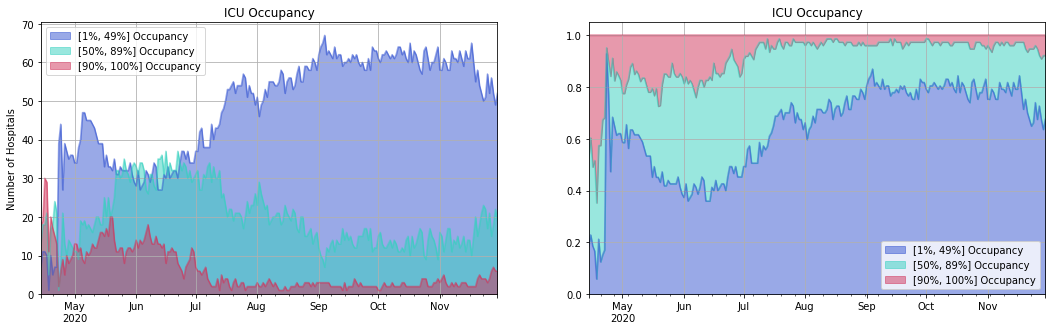

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

capacidad_color = {
    'Buena': '#3454D1', 
    'Media': '#34D1BF', 
    'Crítica': '#D1345B',
    'Sin Dato': 'gray'}

data_plot = capacidad.rename(columns={
    'Buena': '[1%, 49%] Occupancy',
    'Media': '[50%, 89%] Occupancy',
    'Crítica': '[90%, 100%] Occupancy'
})[[
    '[1%, 49%] Occupancy',
    '[50%, 89%] Occupancy',
    '[90%, 100%] Occupancy'
]].fillna(method='ffill')

data_plot.plot(
    title='ICU Occupancy',
    kind='area',
    stacked=False,
    color=[capacidad_color[x] for x in ['Buena', 'Media','Crítica']],
    ax=ax[0],
    grid=True)

ax[0].set_ylabel('Number of Hospitals')

(data_plot.T / data_plot.sum(axis=1)).T[[
    '[1%, 49%] Occupancy',
    '[50%, 89%] Occupancy',
    '[90%, 100%] Occupancy'
]].plot(
    title='ICU Occupancy',
    kind='area',
    stacked=True,
    alpha=.5,
    color=[capacidad_color[x] for x in ['Buena', 'Media','Crítica']],
    ax=ax[1],
    grid=True)

# Hospitals timeline

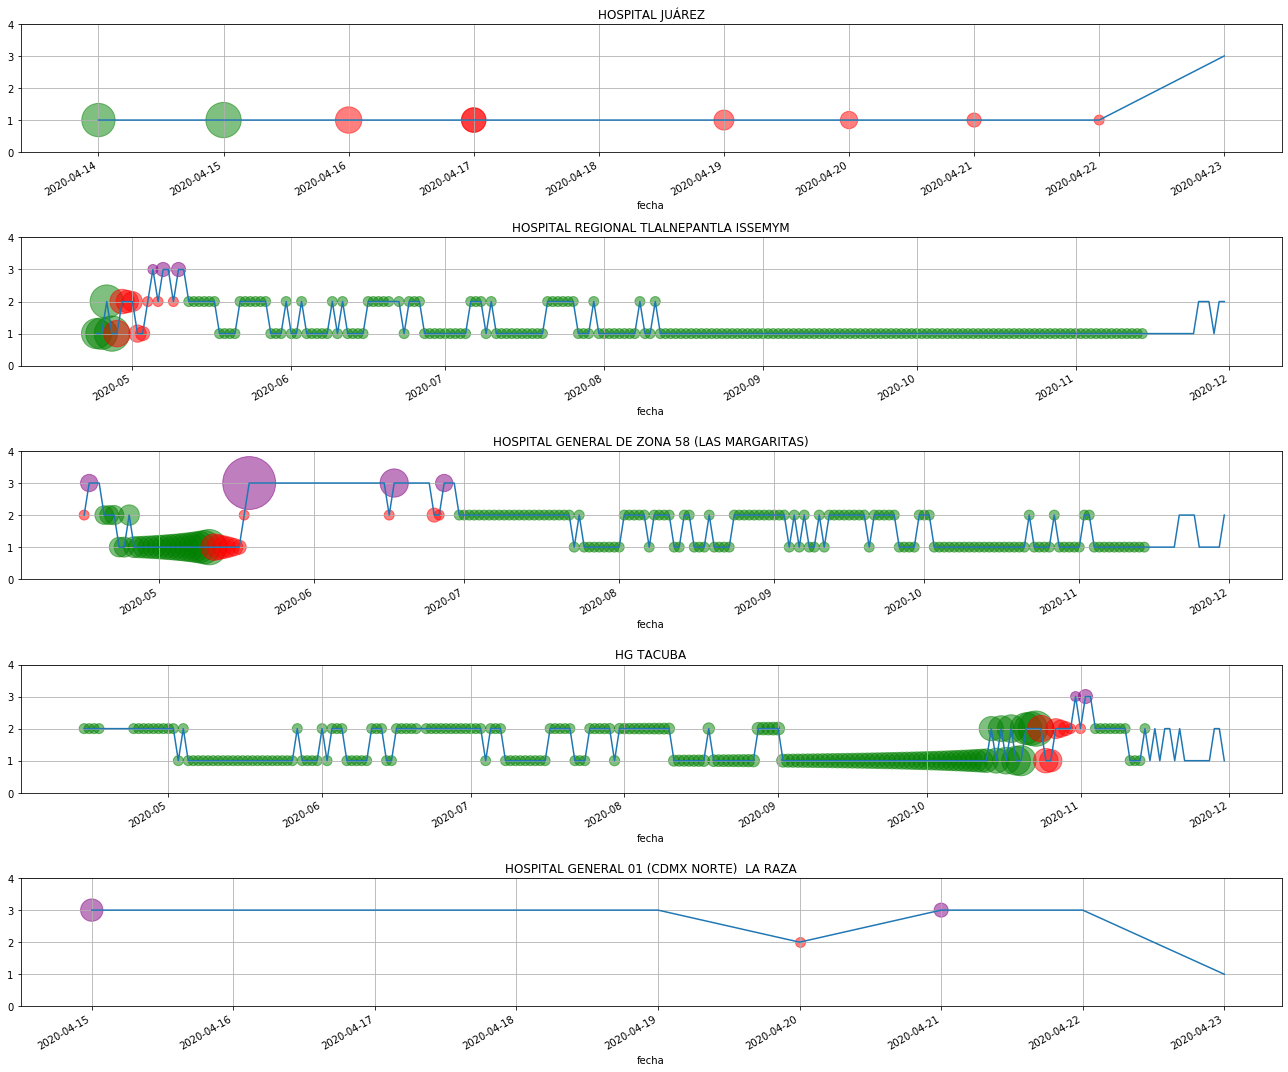

In [13]:
target_name = 'is_next_peak_in_7_days'
n_samples = 5

sample_hospitals = data[
    data['estatus_capacidad_uci'] == 'Crítica'
][
    'nombre_hospital'
].drop_duplicates().sample(
    n_samples, 
    random_state=0)

# sample_hospitals = ['ALTA ESPECIALIDAD DE ZUMPANGO', 'UNIDAD MÓVIL TEMPORAL COVID', 'ALTA ESPECIALIDAD DE ZUMPANGO']

n_sample_hospitals = len(sample_hospitals)

fig, ax = plt.subplots(
    n_sample_hospitals, 1, 
    figsize=(18, n_sample_hospitals * 3))

for it, hospital in enumerate(sample_hospitals):
    hospital_data = data[data['nombre_hospital'] == hospital]
    hospital_peaks_data = peaks_data[peaks_data['nombre_hospital'] == hospital]
    hospital_days_to_peak_data = days_to_peak_data[
        days_to_peak_data['nombre_hospital'] == hospital]
    
    hospital_data.set_index('fecha')['estatus_capacidad_uci_ordinal'].plot(
        marker='',
        markersize=3,
        grid=True, 
        ax=ax[it])
    
    ax[it].set_title(hospital)
    
    ax[it].scatter(
        x=hospital_peaks_data['peak_date'].apply(date2num),
        y=[3] * hospital_peaks_data.shape[0],
        s=hospital_peaks_data['peak_length'] * 100,
        color='purple',
        alpha=.5)
    
    
    binary_color = {
        1: 'red', 
        0: 'green'}
    weight_importance = {
        1: 'days_to_peak', 
        0: 'days_to_peak_inv'
    }
    for is_peak_in_next_n, is_peak_in_next_n_data in hospital_days_to_peak_data.groupby(target_name):
        s = is_peak_in_next_n_data[
            weight_importance[is_peak_in_next_n]]
        
        if is_peak_in_next_n == 0:
             s *= 10000
        else:
            s *= 100
            
        s = s.clip(100, np.inf)
        
        ax[it].scatter(
            x=is_peak_in_next_n_data['fecha'].apply(date2num),
            y=is_peak_in_next_n_data['estatus_capacidad_uci_ordinal'],
            s=s,
            alpha=.5,
            color=binary_color[is_peak_in_next_n])
    
    ax[it].set_ylim(0, 4)

fig.set_tight_layout('tight')